In [272]:
import pandas as pd
import typing
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_json('data/outdoor_temp_data/temp.json')
df= pd.DataFrame(df['observations']['data'])
df['aifstime_utc'] = pd.to_datetime(df['aifstime_utc'])

In [3]:
df = df.drop(['sort_order','wmo','local_date_time','local_date_time_full','name','history_product','lat', 
                                               'lon', 'cloud', 'cloud_base_m', 'cloud_oktas', 'cloud_type_id', 'cloud_type', 
                                               'sea_state', 'swell_dir_worded', 'swell_height', 'swell_period', 'press_tend', 'weather', 'wind_dir'],axis=1)
df = df.set_index('aifstime_utc')

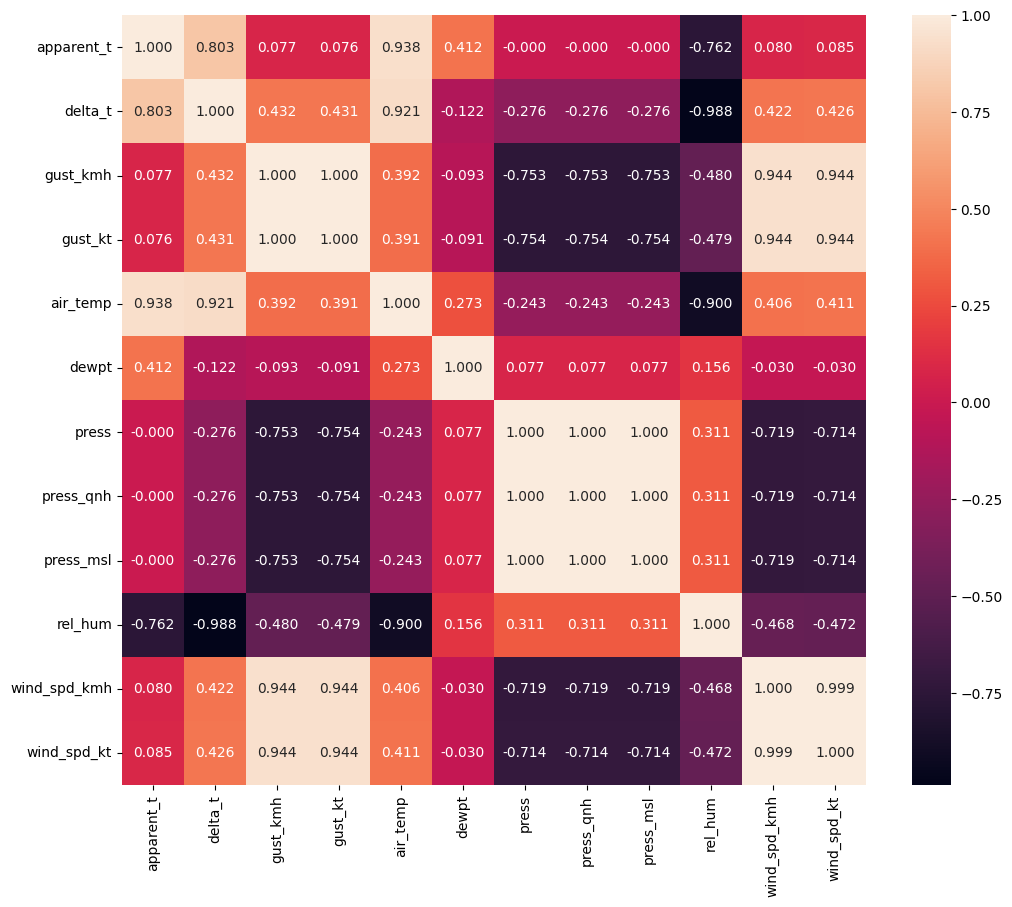

In [4]:
corrMatrix = df.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrMatrix, annot= True, ax=ax, fmt='.3f')
plt.show()

As we can observe rel_hum, dewpt, air_temp, delta_t are highly correated to apparent_temp and delta_t is somewhat correlated to windspd and gust. This means we can drop the rest of features. for temp.

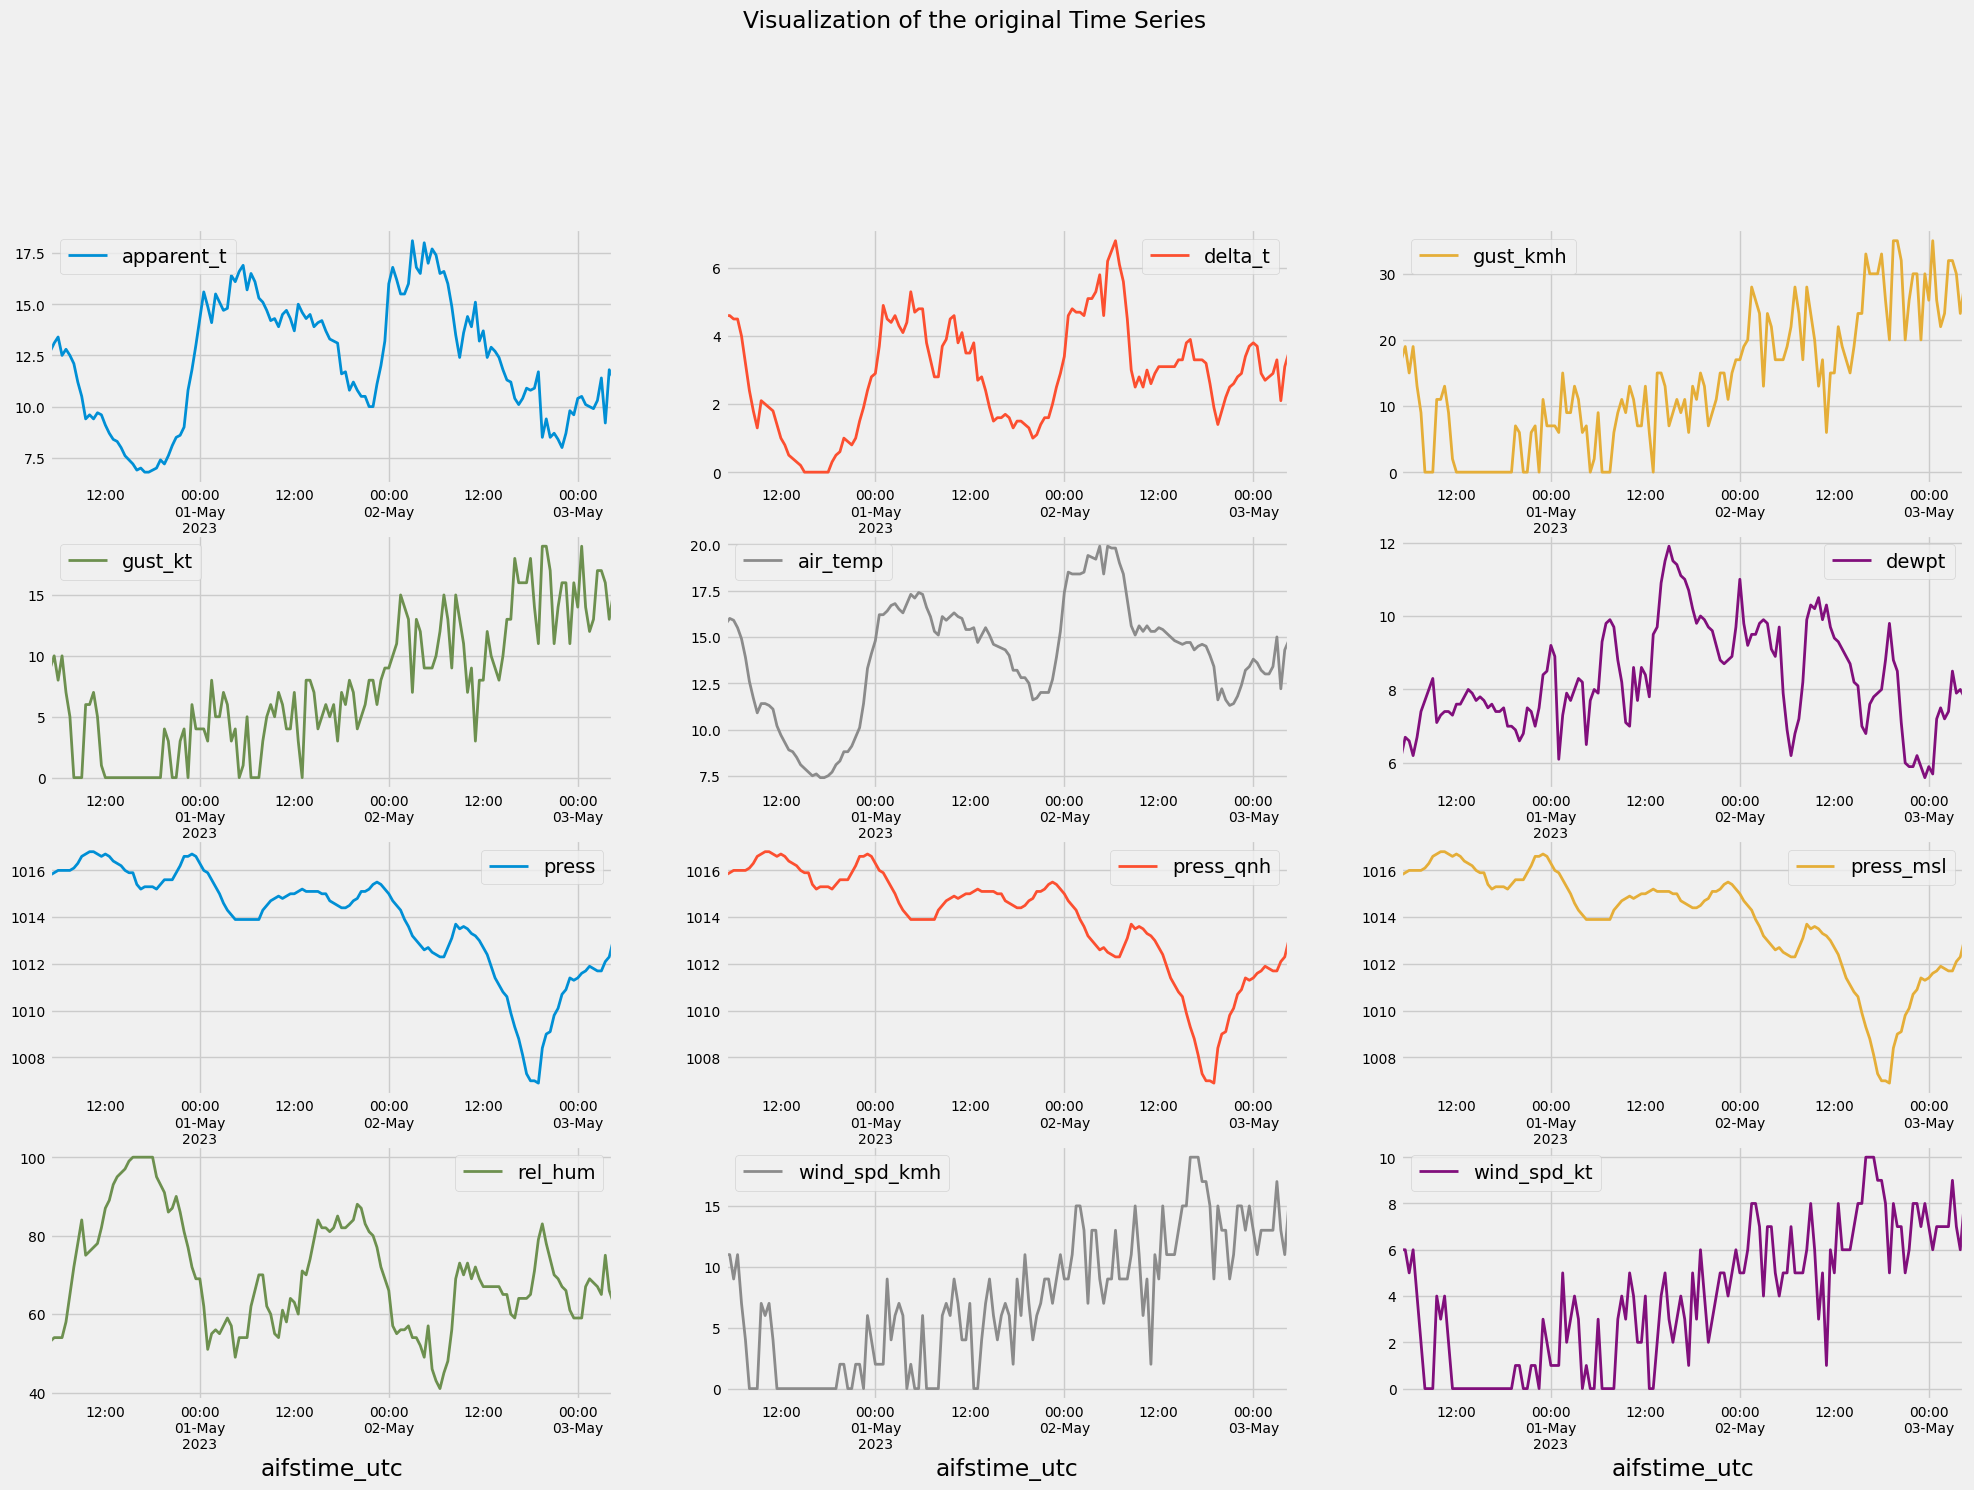

In [5]:
# Plot the time series
plt.style.use('fivethirtyeight')
df.plot(subplots=True,
        layout=(6, 3),
        figsize=(22,22),
        fontsize=10, 
        linewidth=2,
        sharex=False,
        title='Visualization of the original Time Series')
plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler
import numpy as np

In [230]:
df = df.iloc[::-1]

In [241]:
training_size = int ( 0.8 * df.shape[0])  
print(training_size, df.shape)
train_data = df.iloc[:training_size]
val_data = df.iloc[training_size:]

115 (144, 14)


For each prediction we will use last 2 days to predict the third day
2\*24\*1 = 48
to predict 30 min into future, i.e. 1 point

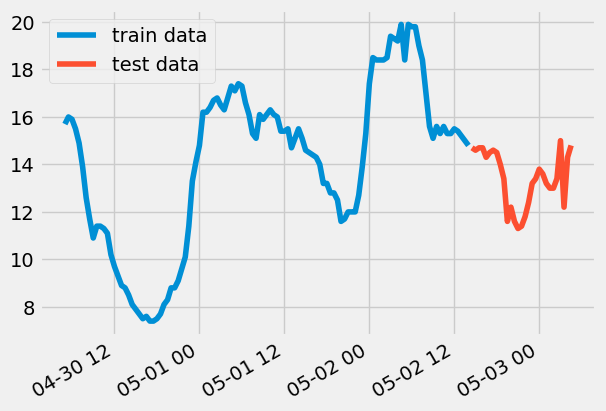

In [242]:
plt.plot(train_data.index, train_data[['air_temp']], label = 'train data')
plt.plot(val_data.index, val_data[['air_temp']], label='test data')
plt.legend()
plt.gcf().autofmt_xdate()

In [128]:
from time import time

(115, 13) (115, 1) (144, 13) (29, 1)
Train data dimensions: (68, 48, 13), (68, 1)
Test data dimensions: (29, 48, 13), (29, 1)
(after normalisation) Test data dimensions: (29, 48, 13), (29, 1)
layers=[12, 12, 12, 1], train_examples=68, test_examples=29
batch = 256, timesteps = 48, features = 13, epochs = 50
lr = 0.1, lambda = 0.05, dropout = 0.0, recurr_dropout = 0.0
Model: "Weather_forcaster"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 24, 14)]          0         
_________________________________________________________________
lstm_104 (LSTM)              (None, 32)                6016      
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 33        
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________
None
Mod

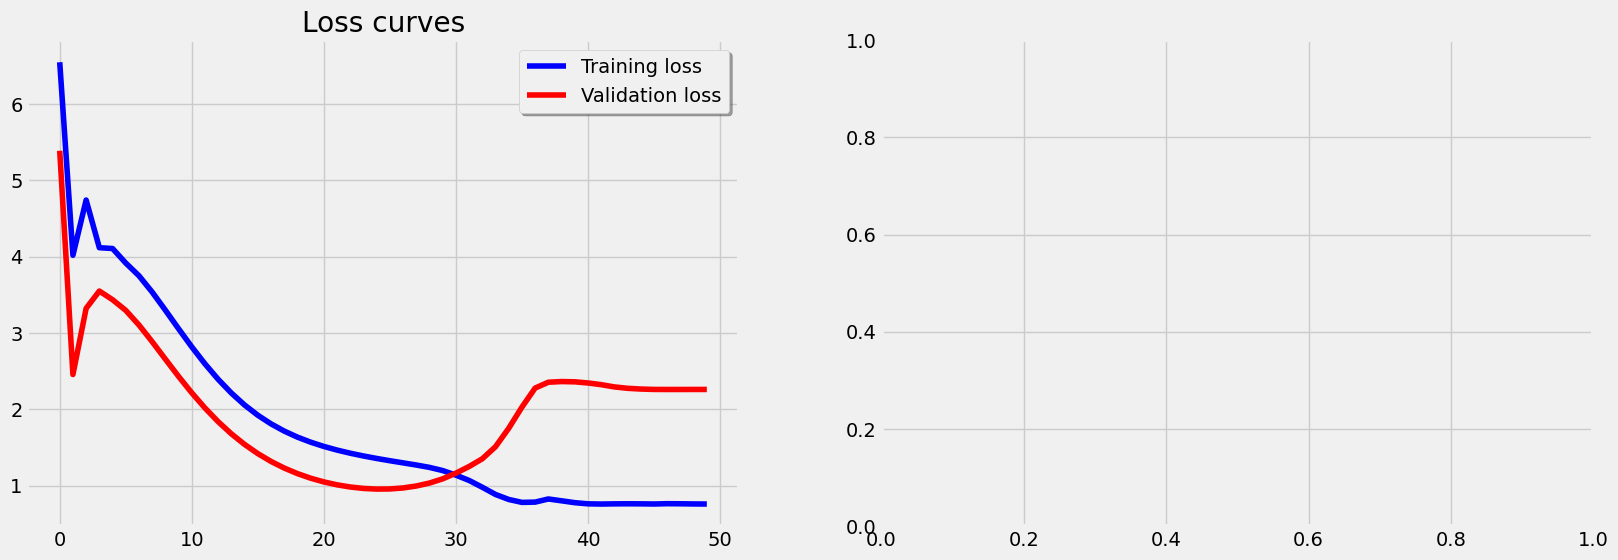

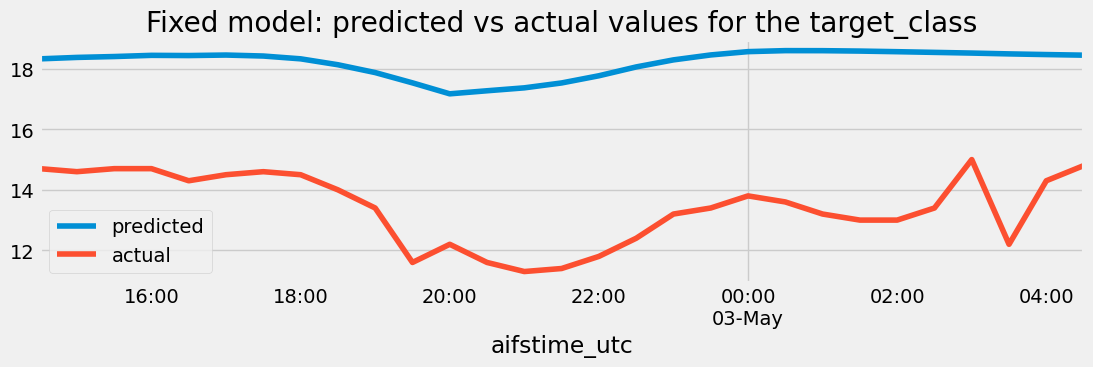

average temperature error: 4.788520050048827


23.73582490608047

In [275]:
# split the data into inputs and targets
past = 48
future = 1
step = 2  # one data point per 30 minutes
sequence_length = (past/step) # 24 hours of data for each input

# I want to use a T-days window of input data for predicting target_class
# It means I need to prepend (T-1) last train records to the 1st test window
T = past  # my choice of the timesteps window
train_features, train_labels  = train_data.drop('air_temp',axis=1), train_data[['air_temp']]
test_features, test_labels = val_data.drop('air_temp',axis=1), val_data[['air_temp']]

prepend_features = train_features.iloc[-(T-1):]
test_features = pd.concat([prepend_features, test_features], axis=0)
# test_features_, train_features = pd.DataFrame(convert_datetime_to_timestamp(test_features_)), pd.DataFrame(convert_datetime_to_timestamp(train_features))

print(train_features.shape, train_labels.shape, test_features_.shape, test_labels.shape)


# Create sequences of T timesteps (=sliding window)
# Normalize sequences X = X/X_0-1, where X_0 is 1st timestep in the window:
X_train, y_train = [], []
for i in range(train_labels.shape[0] - (T-1)):
    X_train.append(train_features.iloc[i:i+T])
    y_train.append(train_labels.iloc[i + (T-1)])
X_train, y_train = np.array(X_train), np.array(y_train)
print(f'Train data dimensions: {X_train.shape}, {y_train.shape}')

X_test, y_test = [], []
for i in range(test_labels.shape[0]):
    X_test.append(test_features_.iloc[i:i+T])
    y_test.append(test_labels.iloc[i])
X_test, y_test = np.array(X_test), np.array(y_test)
print(f'Test data dimensions: {X_test.shape}, {y_test.shape}')

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_x.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)

X_test= scaler_x.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_test= scaler_y.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)

print(f'(after normalisation) Test data dimensions: {X_test.shape}, {y_test.shape}')

# Let's make a list of CONSTANTS for modelling:
LAYERS = [12, 12, 12, 1]             # number of units in hidden and output layers
M_TRAIN = X_train.shape[0]           # number of training examples (2D)
M_TEST = X_test.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train.shape[2]                 # number of features
BATCH = 256                          # batch size
EPOCH = 50                           # number of epochs
LR = 1e-1                            # learning rate of the gradient descent
LAMBD = 5e-2                         # lambda in L2 regularizaion
DP = 0.00                            # dropout rate
RDP = 0.00                           # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')


inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)
model = keras.Model(name="Weather_forcaster",inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=['accuracy'])
print(model.summary())

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(T,N), units=32,
            activation='tanh', recurrent_activation='hard_sigmoid',
            kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            dropout=DP, recurrent_dropout=RDP,
            return_sequences=True, return_state=False,
            stateful=False, unroll=False))
model.add(LSTM(units=LAYERS[1],
            activation='tanh', recurrent_activation='hard_sigmoid',
            kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            dropout=DP, recurrent_dropout=RDP,
            return_sequences=True, return_state=False,
            stateful=False, unroll=False))
model.add(Dense(units=LAYERS[3]))





# # Build the Model
# model = Sequential()
# model.add(LSTM(input_shape=(T,N), units=LAYERS[0],
#             activation='tanh', recurrent_activation='hard_sigmoid',
#             kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
#             dropout=DP, recurrent_dropout=RDP,
#             return_sequences=True, return_state=False,
#             stateful=False, unroll=False))
# model.add(BatchNormalization())
# model.add(LSTM(units=LAYERS[1],
#             # activation='tanh', recurrent_activation='hard_sigmoid',
#             kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
#             dropout=DP, recurrent_dropout=RDP,
#             return_sequences=True, return_state=False,
#             stateful=False, unroll=False))
# model.add(BatchNormalization())
# model.add(LSTM(units=LAYERS[2],
#             activation='tanh', recurrent_activation='hard_sigmoid',
#             kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
#             dropout=DP, recurrent_dropout=RDP,
#             return_sequences=False, return_state=False,
#             stateful=False, unroll=False))
# model.add(BatchNormalization())
# model.add(Dense(units=LAYERS[3]))

# Compile the model with Adam optimizer
model.compile(loss='mse', metrics=['accuracy'],
            optimizer=Adam(lr=LR))
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', patience=1, verbose=0, 
                            factor=0.5, min_lr=1e-8)
# # Define Early Stopping:
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
#                         patience=10, verbose=1, mode='auto',
#                         baseline=0, restore_best_weights=False)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()
History = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH,
                    validation_split=0.2, shuffle=True,verbose=0, callbacks=[lr_decay])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_acc = History.history['accuracy'][-1]    #model.evaluate(X_train, y_train, batch_size=M_TRAIN)
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=M_TEST)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 2)}%')
print(f'fixed model test score = {round(test_acc * 100, 2)}%')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
plt.show()

# Plot predictions vs actual labels for fixed model
# print()
# index = test_features.set_index(test_features[0]).drop(test_features.columns[0], axis=1).index
fixed_predict = model.predict_on_batch(X_test)
averaged = np.mean(fixed_predict[:,3:6,:], axis=1)
# Plot predictions vs actual labels for fixed model
index = test_labels.index
# print(fixed_predict)
dff = pd.DataFrame({'predicted':scaler_y.inverse_transform(averaged).squeeze(), 'actual':scaler_y.inverse_transform(y_test).squeeze()}, index=index)
ax = dff.plot(figsize=(12,3))
ax.set_title('Fixed model: predicted vs actual values for the target_class')
plt.show()
dff = pd.DataFrame({'predicted':scaler_y.inverse_transform(averaged).squeeze(), 'actual':scaler_y.inverse_transform(y_test).squeeze()}, index=index)
print(f"average temperature error: {np.mean(dff['predicted']-dff['actual'])}")
print(f" mse: {mean_squared_error(dff['predicted'], dff['actual'])}")

# for i in range(y_test.shape[1]):
#     fixed_score = np.sum(fixed_predict[:,i] == y_test[:,i]) / y_test.shape[0]
#     print(f'Fixed model test score = {round(fixed_score*100, 2)}%')
#     dff = pd.DataFrame({'predicted':fixed_predict[:,i].squeeze(), 'actual':y_test[:,i].squeeze()}, index=index)
#     ax = dff.plot(figsize=(12,3))
#     ax.set_title('Fixed model: predicted vs actual values for the target_class')
#     plt.show()

online model training

Online model instantiated in 0.25 secs
Online learning completed in 4.07 secs


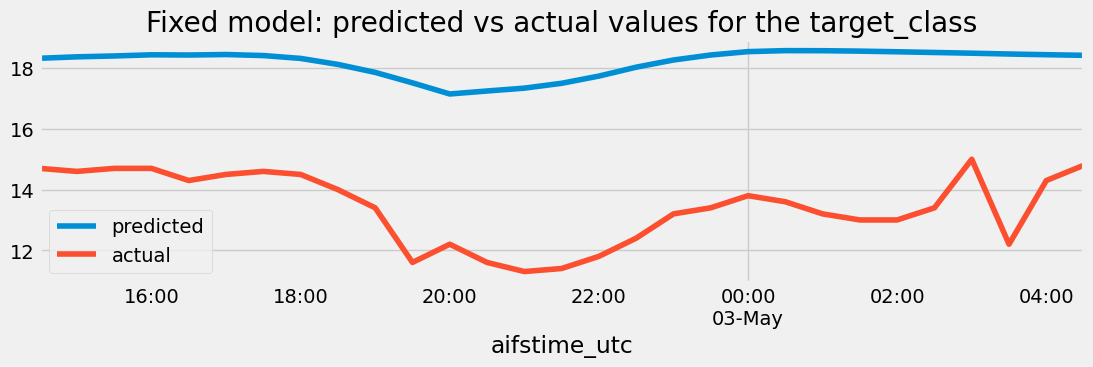

average temperature error: 4.771948347420527
 mse: 23.56482884564121


In [276]:
start = time()
config, weights = model.get_config(), model.get_weights()
online_model = Sequential.from_config(config)
online_model.set_weights(weights)
online_model.compile(loss='mse', optimizer=Adam(lr=LR))
print(f'Online model instantiated in {time() - start:.2f} secs')

# Online training (update model with each new data available):
predictions = []
start = time()
for t in range(y_test.shape[0]):
    x = X_test[t].reshape(-1,T,N)  # a "new" input is available
    y_hat = model.predict_on_batch(x) # predict on the "new" input
    averaged = np.mean(y_hat[:,3:6,:], axis=1)
    predictions.append(averaged)  # save predictions
    y = y_test[t].reshape(-1,1)   # a "new" label is available
    model.train_on_batch(x, y)  # runs a single gradient update 
print(f'Online learning completed in {time() - start:.2f} secs')


# Evaluation of the predictions with online learning
online_predict = np.array(predictions).reshape(-1,1)
dff = pd.DataFrame({'predicted':scaler_y.inverse_transform(online_predict).squeeze(), 'actual':scaler_y.inverse_transform(y_test).squeeze()}, index=index)
ax = dff.plot(figsize=(12,3))
ax.set_title('Fixed model: predicted vs actual values for the target_class')
plt.show()
print(f"average temperature error: {np.mean(dff['predicted']-dff['actual'])}")
print(f" mse: {mean_squared_error(dff['predicted'], dff['actual'])}")





In [108]:


start = past + future
end = start + training_size

x_train = train_data.values
y_train = df.iloc[start:end][['air_temp']].values


x_val_end = len(val_data) - start
label_start = training_size + start
x_val = val_data.iloc[:x_val_end][[i for i in range(step)]].values
y_val = features.iloc[label_start:][[0]]


print(type(y_train))

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    data=x_train,
    targets=y_train,
    sequence_length=sequence_length,
    sampling_rate=6,
    batch_size=64,
)

<class 'numpy.ndarray'>


ValueError: Expected data and targets to have the same number of time steps (axis 0) but got shape(data) = (72, 14); shape(targets) = (47, 1).

In [96]:


x_train = []
y_train = []
for i in range(0, len(train_data) - sequence_length*2, step*2):
    x_train.append(train_data[i:i+sequence_length*2:2])
    y_train.append(train_data[i+sequence_length*2:i+sequence_length*2+2][['air_temp']])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape, y_train.shape)

x_val = []
y_val = []
for i in range(0, len(val_data) - sequence_length*2, step*2):
    x_val.append(val_data[i:i+sequence_length*2:2])
    y_val.append(val_data[i+sequence_length*2:i+sequence_length*2+2][['air_temp']])

x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val.shape, y_val.shape)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_train_scaled = scaler_x.fit_transform(x_train.reshape(-1, x_train.shape[2])).reshape(x_train.shape)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[2])).reshape(y_train.shape)

x_val_normalized = scaler_x.transform(x_val.reshape(-1, x_val.shape[2])).reshape(x_val.shape)
y_val_normalized = scaler_y.transform(y_val.reshape(-1, y_val.shape[2])).reshape(y_val.shape)

print(x_train_scaled.shape, y_train_scaled.shape)
print(x_val_normalized.shape, y_val_normalized.shape)
# # create the train and validation datasets using timeseries_dataset_from_array
# dataset_train = keras.preprocessing.timeseries_dataset_from_array(
#     data=x_train,
#     targets=y_train,
#     sequence_length=sequence_length,
#     sampling_rate=step,
#     batch_size=64
# )

# dataset_val = keras.preprocessing.timeseries_dataset_from_array(
#     data=x_val,
#     targets=y_val,
#     sequence_length=sequence_length,
#     sampling_rate=step,
#     batch_size=64
# )


(6, 24, 14) (6, 2, 1)
(6, 24, 14) (6, 2, 1)
(6, 24, 14) (6, 2, 1)
(6, 24, 14) (6, 2, 1)


In [97]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)
model = keras.Model(name="Weather_forcaster",inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=['accuracy'])
model.summary()
history = model.fit(x_train_scaled, y_train_scaled, epochs=50, batch_size=50,
                        validation_split=0.2,verbose=0)

Model: "Weather_forcaster"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 24, 14)]          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 32)                6016      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 1ms/step - loss: 3.6441 - accuracy: 0.0000e+00
-----------------------------------------------------------------
train accuracy = 0.0%
fixed model test score = 0.0%


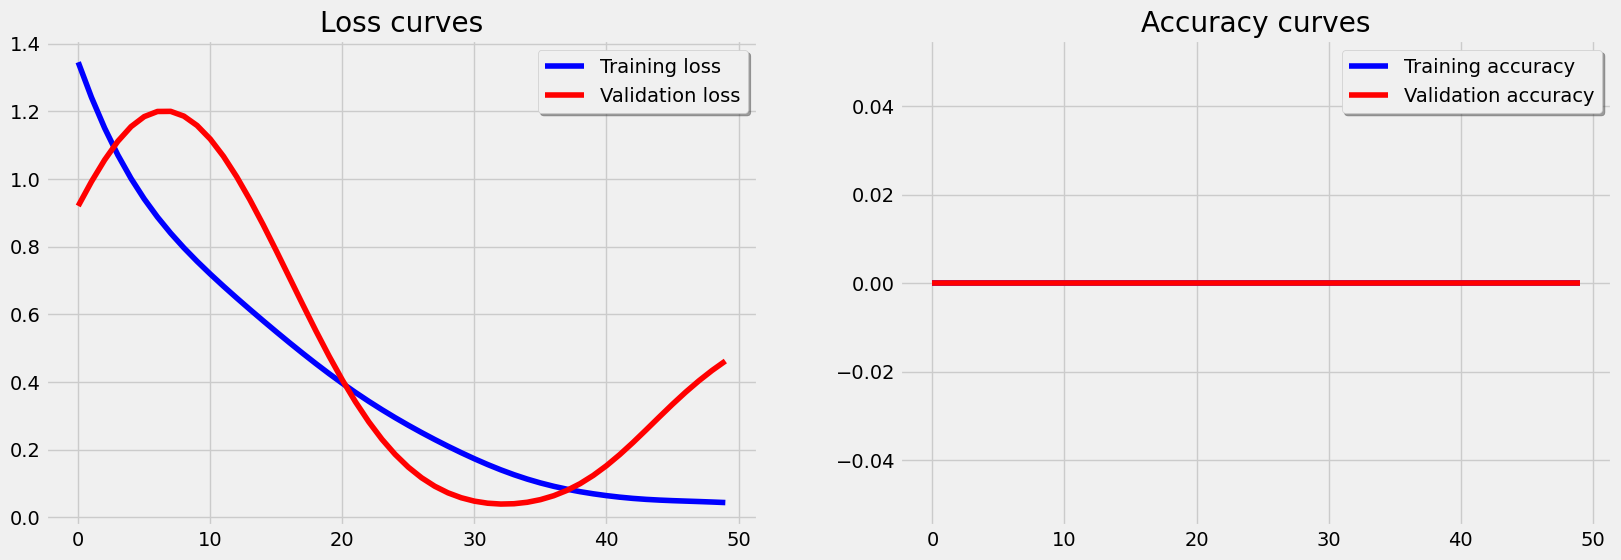

In [98]:
 # Evaluate the model:
train_acc = history.history['accuracy'][-1]    #model.evaluate(X_train, y_train, batch_size=M_TRAIN)
M_TEST = x_val_normalized.shape[0] 
test_loss, test_acc = model.evaluate(x_val_normalized, y_val_normalized, batch_size=M_TEST)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 2)}%')
print(f'fixed model test score = {round(test_acc * 100, 2)}%')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(history.history['loss'], color='b', label='Training loss')
axs[0].plot(history.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

[[0.72564805]
 [0.7602917 ]
 [0.78277016]
 [0.77404326]
 [0.6619337 ]
 [0.77519137]]


ValueError: x and y must have same first dimension, but have shapes (72,) and (6, 1)

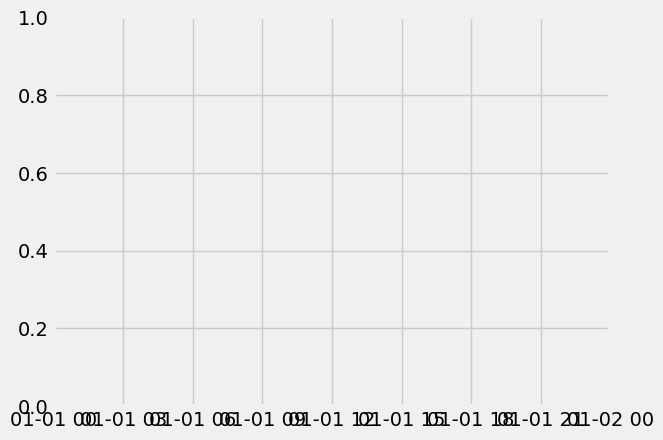

In [103]:

prediction = model.predict_on_batch(x_val_normalized)
print(scaler_y.inverse_transform(prediction))

plt.plot(val_data.index, prediction, alpha = 0.1, color='black')
# Plot the data and label it according to the SVM


# for x, y in dataset_val.skip(1):
#     history_data = x[0][:, 1].numpy() * temp_std + temp_mean
#     true_value = y[0].numpy() * temp_std + temp_mean
#     prediction = model.predict(x)[0] * temp_std + temp_mean
#     time_steps = list(range(-(history_data.shape[0]), 0))
#     plt.plot(time_steps, history_data)
#     plt.plot(36, true_value, "gD")
#     plt.plot(36, prediction, "rX")
#     plt.legend(["History", "True Future", "Model Prediction"])
#     plt.xlabel("Time")
#     plt.show()
#     break